# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 09/14/2021

In [2]:
#Import necessary packages

import pandas as pd #to work with data arrays
!pip uninstall statsmodels
!pip install statsmodels
!pip install geopandas
import geopandas as gpd #to work with spatial data
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels import tsa
!pip install pmdarima
from pmdarima import auto_arima

Found existing installation: statsmodels 0.13.1
Uninstalling statsmodels-0.13.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.13.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.13.1
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


In [3]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
1986.tif  1988.tif  1990.tif  1992.tif  datasets/
1987.tif  1989.tif  1991.tif  1993.tif  pod_pou_lulcc/


In [ ]:
#Import data files

div_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63.csv', parse_dates=['DiversionDate'], index_col=['DiversionDate'])
print(div_wd63.dtypes)

WaterDistrictNumber             int64
HydrologyID                     int64
DiversionName                  object
DiversionTypeDescription       object
MeasurementTypeDescription     object
CFS                           float64
dtype: object


In [ ]:
### CREATE A CSV FILE FOR EACH DIVERSION ###

#This section is useful to clean, sort, and individually export each csv
#Can comment section out after first run 

# div_name = np.unique(div_wd63['DiversionName']) #get unique identifier for each div point
# print(div_name)

# for n in div_name:
#   canal = div_wd63[div_wd63['DiversionName']== n] #creates a dataframe for each canal name
#   canal = canal.sort_index() #sorts data by date
#   file_name = 'datasets/diversion_timeseries/'+ str(n) +'.csv' #creates a file path
#   canal.to_csv(file_name) #exports csv to directory

In [12]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###


all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DiversionDate'], index_col=['DiversionDate'])
  all_files.append(df) #appends dataframes to one file list

In [ ]:
#Plot the data to see the timescale

###----------------------------------###
### CREATES ONE FIGURE FOR ALL PLOTS ###
###----------------------------------###

len(all_files)
i,j = 0,0
plot_row = 4 #number of plots per row in figure
figure, ax = plt.subplots(33, plot_row, figsize=(30,150)) #create the figure
file_len = np.array(np.arange(0,len(all_files),1)) #total count of files

for f in file_len: #run a for loop to add all plots to figure
  canal_data = all_files[f] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'], 'o')
  ax[i][j].set_ylabel('Discharge (cfs)')
  ax[i][j].set_xlabel('Time')
  ax[i][j].title.set_text(canal_data['DiversionName'].iloc[0])
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

###---------------------------------------------###
### CREATES INDIVIDUAL PLOTS FOR EACH DIVERSION ###
###---------------------------------------------###

for f in file_len:
  canal_data = all_files[f]
  fig = plt.figure(figsize= (9,7))
  ax = fig.add_subplot(1,1,1)
  ax.plot(canal_data.index, canal_data['CFS'], 'o')
  ax.set_ylabel('Discharge (cfs)')
  ax.set_xlabel('Time')
  ax.title.set_text(canal_data['DiversionName'].iloc[0])
  file_path = ('datasets/diversion_timeseries/individualplots/'+ canal_data['DiversionName'].iloc[0] +'.png')
  plt.savefig(file_path) #exports the file 


In [13]:
## EXPLORATORY DATA ANALYSIS ##

## Start with 4 known canals: Ridenbaugh, Settlers, Phyllis, Riverside

main_canals = ([all_files[84], all_files[94], all_files[77], all_files[85]])  #subset to the 4 canals
years = np.array(np.arange(2003,2021,1)) #creates an array for the years
totals = np.empty((len(years), len(main_canals))) #create an empty vector to store sums
names = []
for i in range(len(main_canals)):
  sub_canal = main_canals[i]['DiversionName']
  names.append(sub_canal[1])


In [14]:
## QAQC on data

# 1) Make series from Jan 1 2003 to start date of irrigation season and append series
#    to dataframes

dt_series = pd.date_range(start='2003-01-01', end='2003-03-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

canals = []

for i in range(len(main_canals)):
  canal = main_canals[i]
  canal = pd.concat([dt_df, canal])
  canal = canal.asfreq('d')
  canal['CFS'] = canal['CFS'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
  canal['DiversionName'] = canal['DiversionName'].fillna(names[i]) #fills Nan diversion name values
  canals.append(canal)


In [15]:
## Import reservoir fill file to normalize volume to available water

fill = pd.read_csv('datasets/diversion_timeseries/reservoir_fill.csv', parse_dates=['Date'], index_col=['Date'])

max_fill = []

for i in range(len(years)):
  data = fill[fill.index.year == years[i]]
  max_fill.append([years[i], np.max(data['TotalStorage'])])

max_fill = pd.DataFrame(max_fill, columns = ['Year', 'MaxFill'])

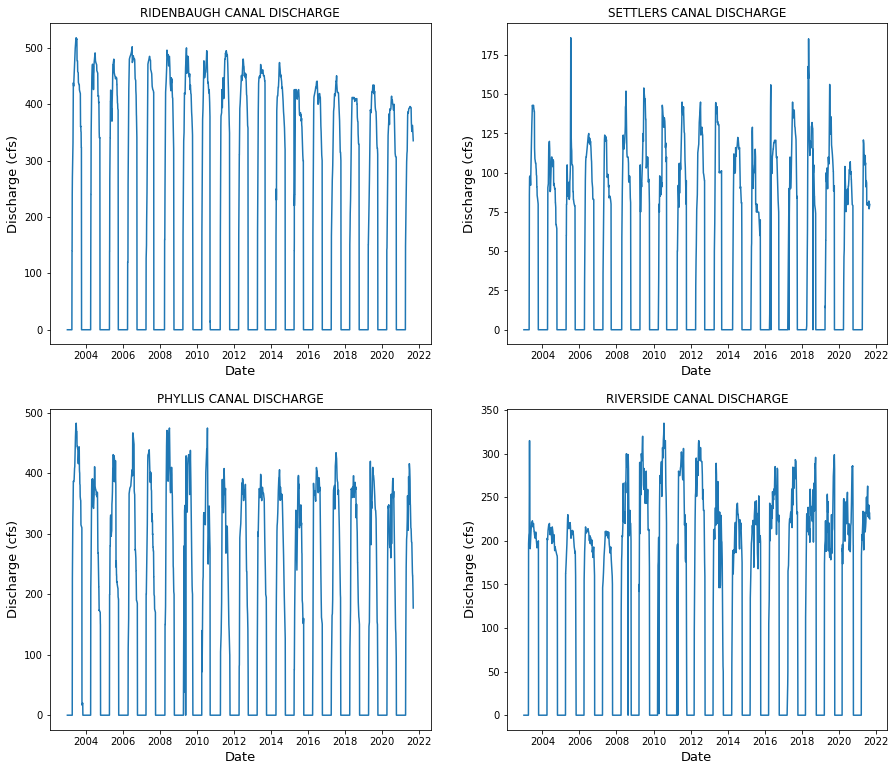

In [16]:
## PLOT THE RAW DATA TO VISUALLY ANALYZE TRENDS AND SEASONALITY

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15,13)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = canals[n] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'])
  ax[i][j].set_ylabel('Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Date', size=13)
  ax[i][j].title.set_text(names[n]+' CANAL DISCHARGE')
  # ax[i][j].set_xticks(years)
  # ax[i][j].set_xticklabels(years, rotation=45)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/rawdata.png')


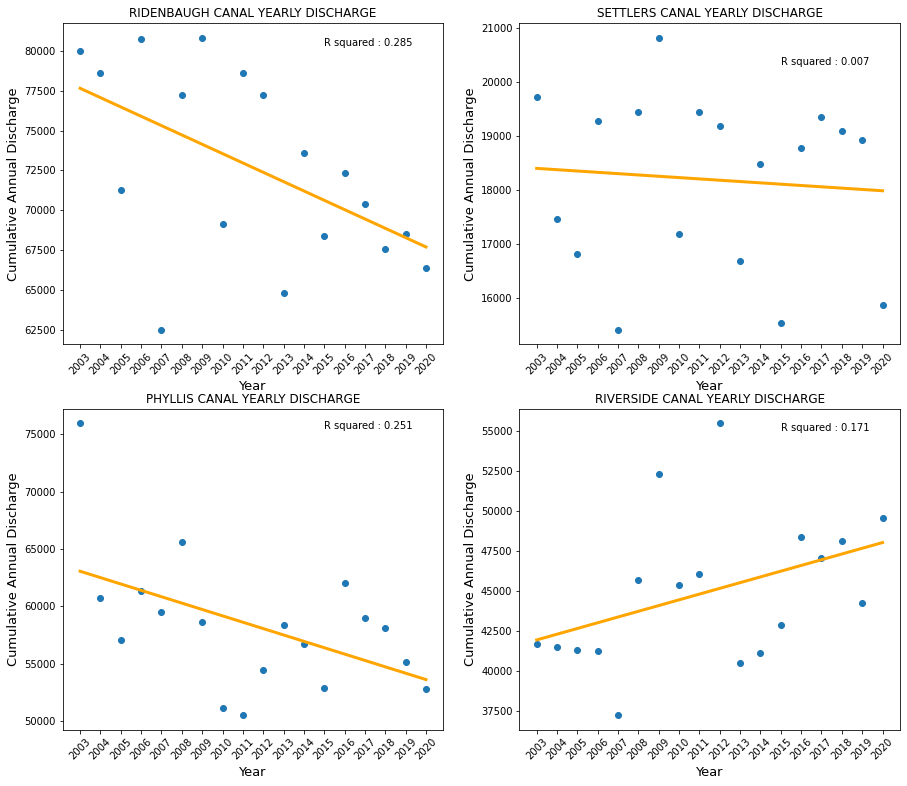

In [20]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

for i in range(len(canals)):
  for y in range(len(years)):
    sub_canal = canals[i]
    Ix = sub_canal.index.year == years[y] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    totals[y][i] = sum(subset_year['CFS']) #sum the total discharge throughout the year
    #need to find a way to normalize the total for the year

## CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(totals[:,i], regression[:,i]) #compares correlation of model to true values


## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15,13)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' CANAL YEARLY DISCHARGE')
  ax[i][j].set_xticks(years)
  ax[i][j].set_xticklabels(years, rotation=45)
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2015, np.max(totals[:,n])-500, s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/totals.png')

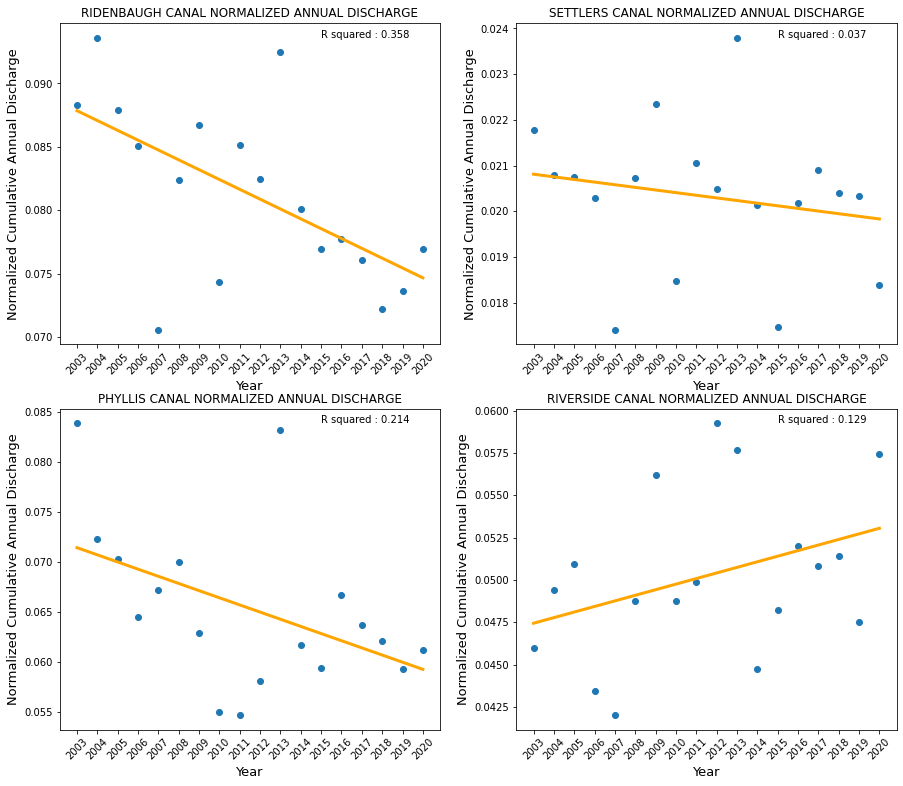

In [21]:
## Normalize total water diverted to the max fill available that year

norm_totals = np.empty((len(years), len(canals)))

for y in range(len(years)):
  for i in range(len(canals)):
    cum_discharge = totals[y][i]
    res_fill = max_fill['MaxFill'][max_fill['Year'] == years[y]]
    norm_totals[y][i] = cum_discharge/res_fill

# CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, norm_totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(norm_totals[:,i], regression[:,i]) #compares correlation of model to true values


## Plot the normalized discharges

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15, 13)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = norm_totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Normalized Cumulative Annual Discharge', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' CANAL NORMALIZED ANNUAL DISCHARGE')
  ax[i][j].set_xticks(years)
  ax[i][j].set_xticklabels(years, rotation=45)
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2015, np.max(norm_totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/norm_totals.png')


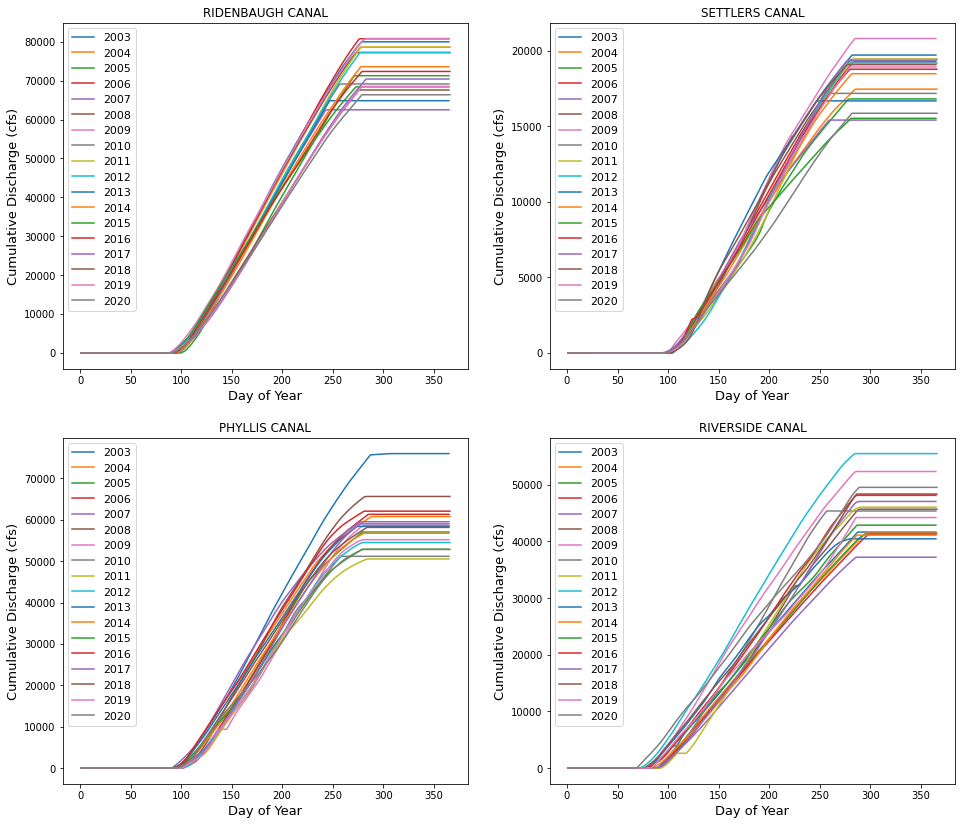

In [30]:
## CUMULATIVE SUMS DAILY ##

#Create a loop to sum the total water diverted for every year

years = np.array(np.arange(2003,2021,1)) #creates an array for the years
cumsum_years = []

for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    Ix = sub_canal.index.year == years[j] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    series_cfs = pd.Series(subset_year['CFS'])
    cumsum_daily = series_cfs.cumsum()
    cumsum_years.append(cumsum_daily)

#Plot the cumulative sum by the day of year

year = np.array(np.arange(0,72,1))
fig3 = plt.figure(figsize = (16,14))
ax = fig3.add_subplot(2,2,1)
ax1 = fig3.add_subplot(2,2,2)
ax2 = fig3.add_subplot(2,2,3)
ax3 = fig3.add_subplot(2,2,4)
for i in range(len(year)):
  if year[i]<18:
    ax.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax.legend(years, fontsize=11)
    ax.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax.set_xlabel('Day of Year', size=13)
    ax.set_title(names[0]+' CANAL') #add the name of the canal
  elif year[i]<36:
    ax1.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax1.legend(years, fontsize=11)
    ax1.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax1.set_xlabel('Day of Year', size=13)
    ax1.set_title(names[1]+' CANAL')
  elif year[i]<54:
    ax2.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax2.legend(years, fontsize=11)
    ax2.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax2.set_xlabel('Day of Year', size=13)
    ax2.set_title(names[2]+' CANAL')
  else:
    ax3.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax3.legend(years, fontsize=11)
    ax3.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax3.set_xlabel('Day of Year', size=13)
    ax3.set_title(names[3]+' CANAL')
plt.legend(years, fontsize=11)
plt.savefig('datasets/diversion_timeseries/figures/cumsum.png')
plt.show()

In [25]:
## Calculate basic statistics

stats = []

for i in range(len(canals)):
  canal = canals[i]
  avg = np.mean(canal['CFS'][canal['CFS'] != 0])
  std_dev = np.std(canal['CFS'][canal['CFS'] != 0])
  avg_withzero = np.mean(canal['CFS'])
  std_withzero = np.std(canal['CFS'])
  coeff_var = std_dev/avg
  coeff_var_withzero = std_withzero/avg_withzero
  maximum = np.max(canal['CFS'])
  minimum = np.min(canal['CFS'][canal['CFS'] != 0])
  stats.append([names[i], avg, std_dev, coeff_var, maximum, minimum, avg_withzero, std_withzero, coeff_var_withzero])

base_stats = pd.DataFrame(stats, columns = ['DiversionName', 'Mean', 'Standard_dev', 
                                            'Coefficient_Variation', 'Maximum', 'Minimum', 
                                            'Mean_ZeroValues', 'Standard_dev_ZeroValues',
                                            'Coefficient_ZeroValues'])


display(base_stats)
base_stats.to_csv('datasets/diversion_timeseries/figures/stats.csv')



,DiversionName,Mean,Standard_dev,Coefficient_Variation,Maximum,Minimum,Mean_ZeroValues,Standard_dev_ZeroValues,Coefficient_ZeroValues
0,RIDENBAUGH,399.855664,79.522865,0.198879,518.0,5.00,199.576259,207.671368,1.040561
1,SETTLERS,101.681740,26.444748,0.260074,186.0,0.36,49.931933,54.105258,1.083580
2,PHYLLIS,314.984036,95.116853,0.301974,483.0,16.70,160.584622,171.483549,1.067870
3,RIVERSIDE,221.367792,44.879122,0.202736,335.0,1.80,124.146328,114.887966,0.925424


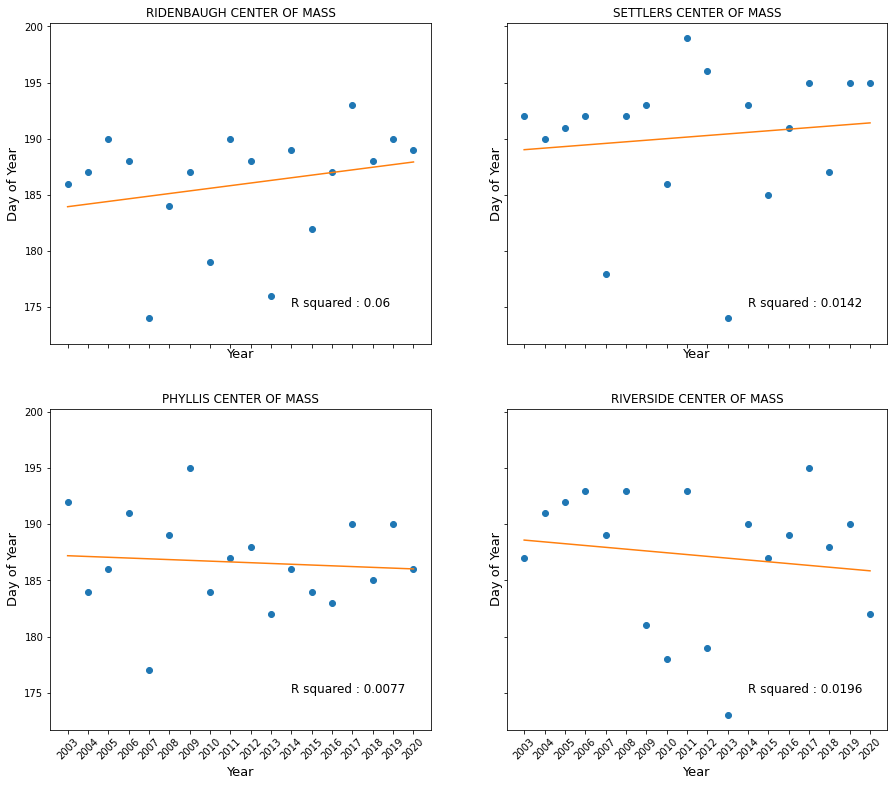

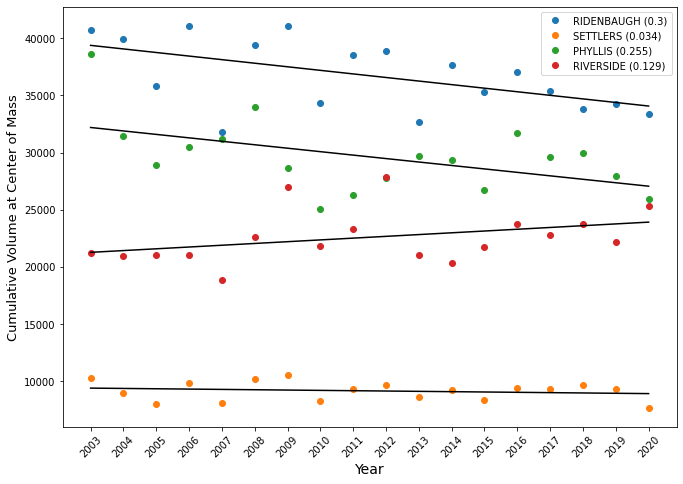

In [32]:
## FIND THE CENTER OF MASS OF THE IRRIGATION SEASON ##

centroid = np.empty((len(years), len(canals)))
centroid_day = []

for i in range(len(years)):
  for n in range(len(canals)):
    canal = canals[n]
    year = canal[canal.index.year == years[i]]
    centroid[i][n] = round(sum(year.index.dayofyear*year['CFS'])/sum(year['CFS']))
    centroid_day.append(centroid[i][n])

## Find the volume at the centroid

centroid_vol = np.empty((len(years), len(canals)))
centroid_volume = []

for i in range(len(years)):
  for n in range(len(canals)):
    canal = canals[n]
    year = canal[canal.index.year == years[i]]
    centroid_day = centroid[i][n]
    centroid_vals = year[year.index.dayofyear<=centroid_day]
    centroid_vol[i][n] = sum(centroid_vals['CFS'])
    centroid_volume.append(sum(centroid_vals['CFS']))

## Check to see if there is a trend in the data through time

regression = np.empty((len(years), len(canals)))
r_squared = np.empty(len(canals))

for i in range(len(canals)):
  model = np.polyfit(years, centroid[:,i], deg=1)
  regression [:,i] = np.polyval(model, years)
  r_squared[i] = metrics.r2_score(centroid[:,i], regression[:,i])

regression_vol = np.empty((len(years), len(canals)))
r_squared_vol = np.empty(len(canals))

for i in range(len(canals)):
  model = np.polyfit(years, centroid_vol[:,i], deg=1)
  regression_vol [:,i] = np.polyval(model, years)
  r_squared_vol[i] = metrics.r2_score(centroid_vol[:,i], regression_vol[:,i])

## PLOT THE DAY AT CENTER OF MASS FOR EACH CANAL ##

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(2, plot_row, figsize=(15,13), sharex=True, sharey=True) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = centroid[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n])
  ax[i][j].set_ylabel('Day of Year', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(names[n]+' CENTER OF MASS')
  ax[i][j].tick_params('both')
  ax[i][j].set_xticks(years)
  ax[i][j].set_xticklabels(years, rotation=45)
  ax[i][j].text(2014, 175, s='R squared : ' + str(np.around(r_squared[n], 4)), size=12)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/centroid_time.png')

## PRESENT THE VOLUME AT THE DAY OF CENTER OF MASS FOR EACH CANAL AS A TIMESERIES ##

fig6 = plt.figure(figsize=(11,17))
ax = fig6.add_subplot(2,1,1)
plt.xticks(years, years, rotation= 45)
ax.plot(years, centroid_vol, 'o')
ax.plot(years, regression_vol, color = 'black')
ax.set_ylabel('Cumulative Volume at Center of Mass', size=13)
ax.set_xlabel('Year', size=14)
leg = []
for i in range(len(names)):
  leg.append(names[i] + ' (' + str(np.around(r_squared_vol[i], 3)) + ')')
ax.legend(leg)
plt.savefig('datasets/diversion_timeseries/figures/centroid_vol.png')
plt.show()

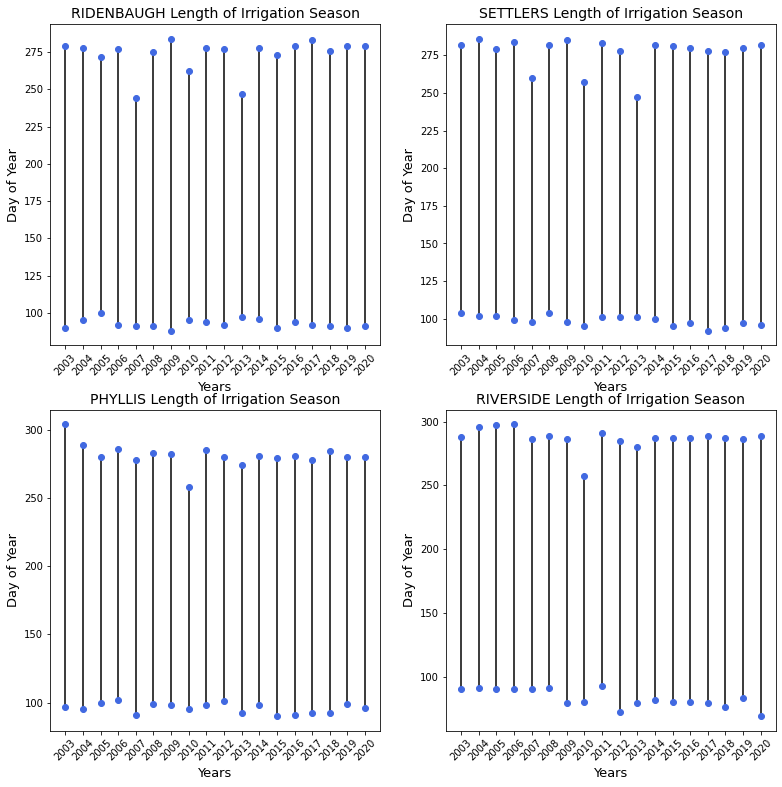

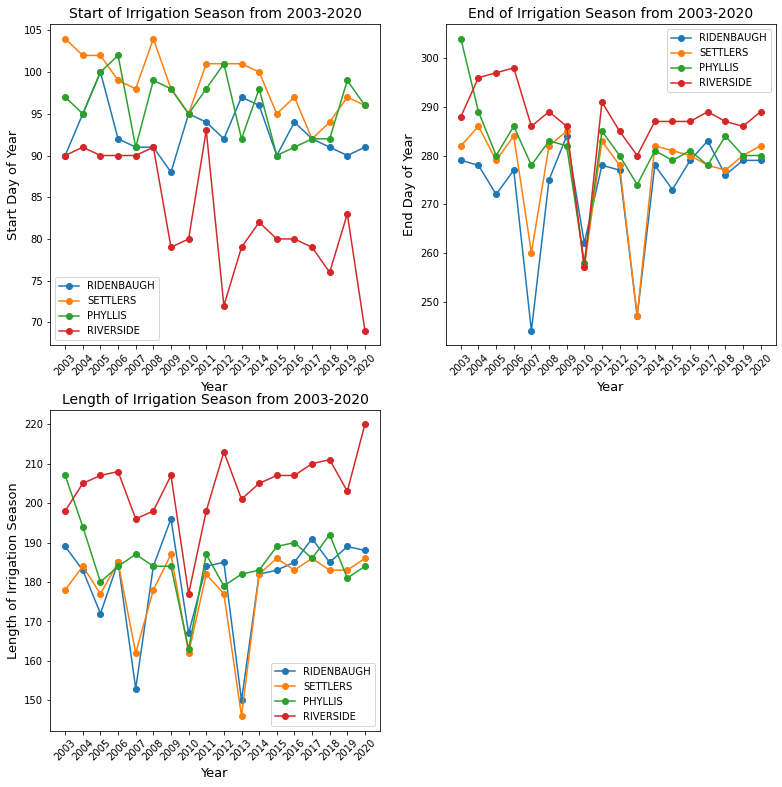

In [41]:
## PLOT LENGTH OF IRRIGATION SEASON ##

## Create a dataframe housing info:                 ##
## ------------------------------------------------ ##
## Column 1: Name of diversion                      ##
## Column 2: Date start of Irrigation season        ##
## Column 3: Day of year start of Irrigation season ##
## Column 4: Date end of irrigation season          ##
## Column 5: Date of year end of Irrigation season  ##
## Column 6: Length of Irrigation Season            ##
## ------------------------------------------------ ##

length = []

for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    canals[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['CFS'].cumsum()

for i in range(len(canals)):
  for y in range(len(years)):
    canal_data = canals[i]
    canal_name = canal_data['DiversionName'][1]
    canal_by_year = canal_data[canal_data.index.year == years[y]]
    min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
    min_Ix = min_Ix[0]
    min_Ix = min_Ix[-1]
    start_date = canal_by_year.index[min_Ix]
    start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
    max_Ix = np.where(canal_by_year['Sum'] == np.max(canal_by_year['Sum']))
    max_Ix= max_Ix[0]
    max_Ix = max_Ix[0]
    end_date = canal_by_year.index[max_Ix]
    end_dayofyear = canal_by_year.index.dayofyear[max_Ix]
    irrig_season_range = end_dayofyear-start_dayofyear
    length.append([canal_name, start_date, start_dayofyear, end_date, end_dayofyear, irrig_season_range])

season_df = pd.DataFrame(length, columns = ['DiversionName', 'StartDate', 'StartDayofYear',
                                            'EndDate', 'EndDayofYear', 'Range'])
season_df.to_csv('datasets/diversion_timeseries/figures/timing.csv')


## Visualize the length of irrigation season ##

y,x = 0,0
fig1, ax = plt.subplots(2,2, figsize=(13,13))

for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  dates = np.empty((18,2))
  dates[:,0] = canal['StartDayofYear']
  dates[:,1] = canal['EndDayofYear']
  ax[y][x].vlines(years, canal['StartDayofYear'], canal['EndDayofYear'])
  ax[y][x].plot(years, dates,'o',color = 'royalblue')
  ax[y][x].set_xticks(years)
  ax[y][x].set_xticklabels(years, rotation=45)
  ax[y][x].set_xlabel('Years', size=13)
  ax[y][x].set_ylabel('Day of Year', size=13)
  ax[y][x].set_title(names[i]+' Length of Irrigation Season', size=14)
  x += 1 
  if x%2 == 0:
    y+=1
    x=0
plt.savefig('datasets/diversion_timeseries/figures/irrig_length.png')
plt.show()

## Visualize the start day, end day, and length of irrigation season ##

fig = plt.figure(figsize = (13,13))
ax = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)

for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  ax.plot(years, canal['StartDayofYear'], 'o-')
  ax.legend(names)
  ax.set_ylabel('Start Day of Year', size=13)
  ax.set_xlabel('Year', size=13)
  ax.set_xticks(years)
  ax.set_xticklabels(years, rotation=45)
  ax.set_title('Start of Irrigation Season from 2003-2020', size=14)
for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  ax1.plot(years, canal['EndDayofYear'], 'o-')
  ax1.legend(names)
  ax1.set_ylabel('End Day of Year', size=13)
  ax1.set_xlabel('Year', size=13)
  ax1.set_xticks(years)
  ax1.set_xticklabels(years, rotation=45)
  ax1.set_title('End of Irrigation Season from 2003-2020', size=14)
for i in range(len(names)):
  canal = season_df[season_df['DiversionName'] == names[i]]
  ax2.plot(years, canal['Range'], 'o-')
  ax2.legend(names)
  ax2.set_ylabel('Length of Irrigation Season', size=13)
  ax2.set_xlabel('Year', size=13)
  ax2.set_xticks(years)
  ax2.set_xticklabels(years, rotation=45)
  ax2.set_title('Length of Irrigation Season from 2003-2020', size=14)

plt.savefig('datasets/diversion_timeseries/figures/timing_stats.png')
plt.show()


In [49]:
## BASIC STATISTICS ON TIMING

time_stats = []

for i in range(len(canals)):
  canal_timing = season_df[season_df['DiversionName'] == names[i]]
  avg_start = np.mean(canal_timing['StartDayofYear'])
  std_start = np.std(canal_timing['StartDayofYear'])
  avg_end = np.mean(canal_timing['EndDayofYear'])
  std_end = np.std(canal_timing['EndDayofYear'])
  avg_length = np.mean(canal_timing['Range'])
  std_length = np.std(canal_timing['Range'])
  avg_centroid = np.mean(centroid[:,i])
  std_centroid = np.std(centroid[:,i])
  avg_centroidvol = np.mean(centroid_vol[:,i])
  std_centroidvol = np.std(centroid_vol[:,i])
  time_stats.append([names[i], avg_start, std_start, avg_end, std_end, avg_length, 
                     std_length, avg_centroid, std_centroid, avg_centroidvol,
                     std_centroidvol])
  
time_stats = pd.DataFrame(time_stats, columns = ['DivName', 'avg_start', 'std_start', 
                                                 'avg_end','std_end', 'avg_length', 
                                                 'std_length','avg_centroid', 'std_centroid', 
                                                 'avg_centroidvol', 'std_centroidvol'])

time_stats.to_csv('datasets/diversion_timeseries/figures/time_stats.csv')
display(time_stats)

,DivName,avg_start,std_start,avg_end,std_end,avg_length,std_length,avg_centroid,std_centroid,avg_centroidvol,std_centroidvol
0,RIDENBAUGH,92.722222,2.921293,273.333333,10.857665,180.611111,12.046848,185.944444,4.960648,36717.745556,2953.349075
1,SETTLERS,98.666667,3.366502,276.833333,10.430990,178.166667,10.547512,190.222222,6.115150,9162.070556,799.317480
2,PHYLLIS,95.888889,3.680110,281.222222,8.337036,185.333333,8.299933,186.611111,4.084373,29623.505556,3103.919181
3,RIVERSIDE,83.000000,6.936217,286.944444,8.455585,203.944444,8.777954,187.222222,5.968022,22593.612778,2245.782139


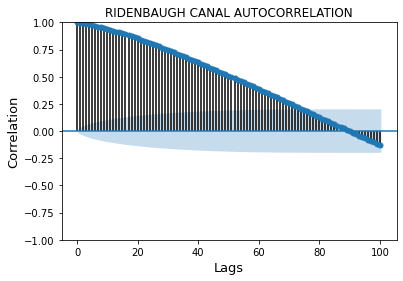

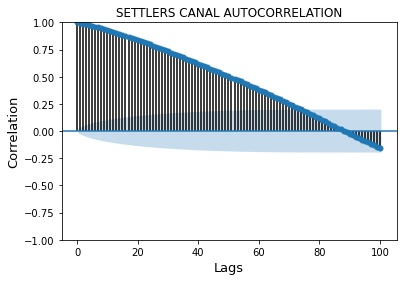

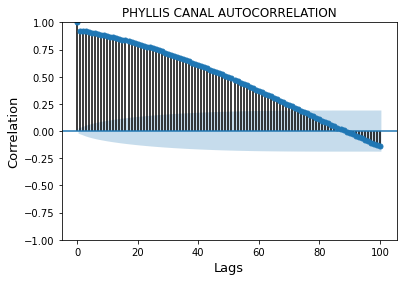

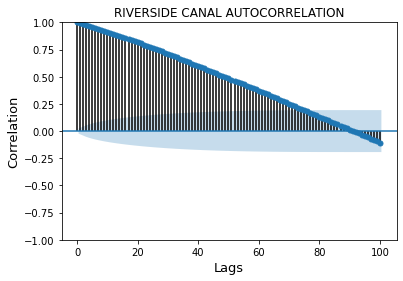

In [16]:
## REMOVE SEASONAL TREND IN THE DATA ##

#Run autocorrelation function

acf = []
for i in range(len(canals)):
  irrig = canals[i]
  acf.append(plot_acf(irrig['CFS'], title = irrig['DiversionName'][1]+' CANAL AUTOCORRELATION', lags=100))
  plt.ylabel('Correlation', size=13)
  plt.xlabel('Lags', size=13)
  plt.savefig('datasets/diversion_timeseries/figures/acf'+names[i]+'.png')

#The mean is not stationary, does not have first order stationarity



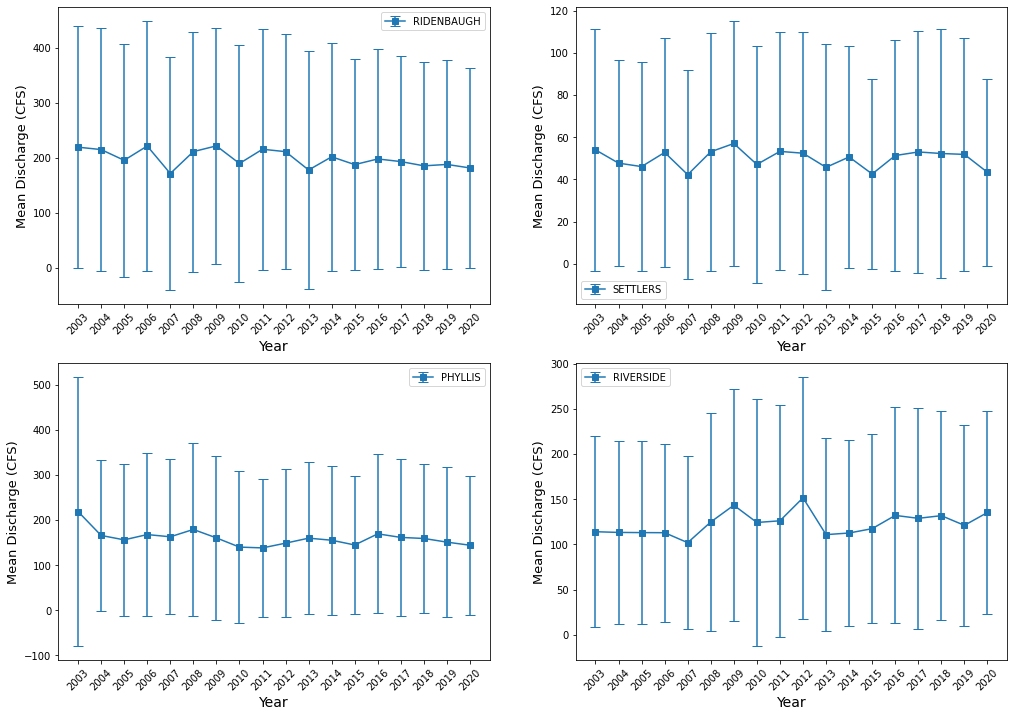

In [17]:
## FIND THE MEAN AND STD DEVIATION ACROSS THE YEARS FOR EACH CANAL

mean_vector = np.empty((len(years), len(canals)))
std_vector = np.empty((len(years), len(canals)))

for i in range(len(years)):
  for n in range(len(canals)):
    canal = canals[n]
    year = canal[canal.index.year == years[i]]
    mean_vector[i][n] = np.mean(year['CFS'])
    std_vector[i][n] = np.std(year['CFS'])

fig6 = plt.figure(figsize=(17,12))
ax = fig6.add_subplot(2,2,1)
ax1 = fig6.add_subplot(2,2,2)
ax2 = fig6.add_subplot(2,2,3)
ax3 = fig6.add_subplot(2,2,4)
ax.errorbar(years, mean_vector[:,0], yerr=std_vector[:,0], marker='s', capsize=5)
ax.set_ylabel('Mean Discharge (CFS)', size=13)
ax.set_xlabel('Year', size=14)
ax.legend([names[0]])
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45)
ax1.errorbar(years, mean_vector[:,1], yerr=std_vector[:,1], marker='s', capsize=5)
ax1.set_ylabel('Mean Discharge (CFS)', size=13)
ax1.set_xlabel('Year', size=14)
ax1.legend([names[1]])
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)
ax2.errorbar(years, mean_vector[:,2], yerr=std_vector[:,2], marker='s', capsize=5)
ax2.set_ylabel('Mean Discharge (CFS)', size=13)
ax2.set_xlabel('Year', size=14)
ax2.legend([names[2]])
ax2.set_xticks(years)
ax2.set_xticklabels(years, rotation=45)
ax3.errorbar(years, mean_vector[:,3], yerr=std_vector[:,3], marker='s', capsize=5)
ax3.set_ylabel('Mean Discharge (CFS)', size=13)
ax3.set_xlabel('Year', size=14)
ax3.legend([names[3]], loc='upper left')
ax3.set_xticks(years)
ax3.set_xticklabels(years, rotation=45)
plt.show()



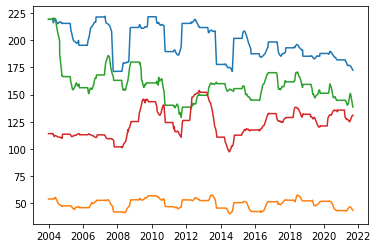

In [18]:
## DETECT A TREND ##

sma = []

for i in range(len(canals)):
  canal = canals[i]
  sma.append((canal['CFS'].rolling(window=365).mean()))
  plt.plot(sma[i])



In [19]:
## Test if time series is stationary ##

## Augmented Dickey Fuller Test tests for stationarity
## Null hypothesis: time series is NOT stationary

fuller = np.empty((len(canals), 2))

for i in range(len(canals)):
  canal = canals[i]
  test = adfuller(canal['CFS']) 
  fuller[i,0] = test[0]
  fuller[i,1] = test[1]

stationary_test = pd.DataFrame(fuller, columns=['f-statistic', 'p-value'])
stationary_test['DiversionName'] = names
print(stationary_test)

   f-statistic       p-value DiversionName
0    -6.065742  1.183015e-07    RIDENBAUGH
1    -6.006261  1.612822e-07      SETTLERS
2    -6.723724  3.431402e-09       PHYLLIS
3    -5.786001  4.997861e-07     RIVERSIDE


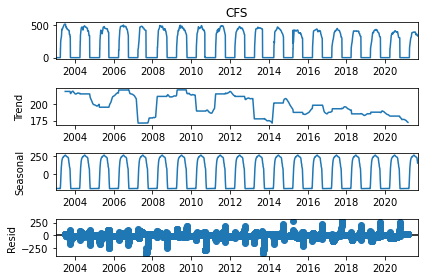

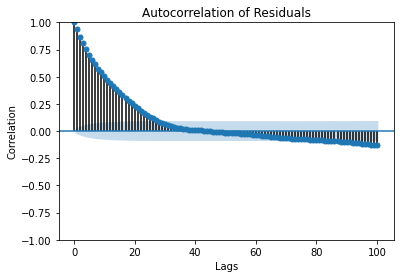

In [20]:
## Seasonal decomposition of the data ##

rid = canals[0]
rid = rid.asfreq('d')
rid = rid.fillna(value=0)
decomp = seasonal_decompose(rid['CFS'], model='additive', period=365)
decomp.plot()
plt.show()
resid = decomp.resid
nan_data = np.isnan(resid) #calls the nan values and creates a bool for nan vs number
not_nan_data = ~ nan_data #takes all the "True" values
data = resid[not_nan_data] #uses the location of the true values to create new array with no nan
plot_acf(data, title = 'Autocorrelation of Residuals', lags=100)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

In [22]:
## AUTO ARIMA ## 

rid = canals[0]

rid_arima = auto_arima(rid['CFS'], start_p=1, start_q=1, max_p=3, max_q=3,
                       seasonal=True, d=0)

In [23]:
rid_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6824
Model:               SARIMAX(1, 0, 3)   Log Likelihood              -29411.182
Date:                Mon, 29 Nov 2021   AIC                          58834.364
Time:                        16:11:39   BIC                          58875.333
Sample:                             0   HQIC                         58848.499
                               - 6824                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9386      0.741      1.267      0.205      -0.514       2.391
ar.L1          0.9951      0.004    250.530      0.000       0.987       1.003
ma.L1          0.0977      0.004     23.090      0.000       0.089       0.106
ma.L2          0.0435      0.016      2.791      0.005       0.013       0.074
ma.L3          0.0429      0.015      2.803      0.005       0.013       0.073
sigma2       323.9836      1.437    225.505      0.000     321.168     326.800
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):          17626622.61
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                           -11.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       250.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""